In [1]:
# For Jupyter Notebook
# import torch

# def format_pytorch_version(version):
#   return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#   return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric 

In [2]:
import numpy as np
import pandas as pd
import pickle
import csv
import os
import torch
from torch_geometric.data import Data

In [3]:
np.random.seed(42)

In [4]:
df = pd.read_csv('./data/yoochoose-clicks.dat')
df.columns = ['session_id', 'timestamp', 'item_id', 'category']
df.head()

C:\Users\acer\Anaconda3\envs\graphlearning\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,session_id,timestamp,item_id,category
0,1,2014-04-07T10:54:09.868Z,214536500,0
1,1,2014-04-07T10:54:46.998Z,214536506,0
2,1,2014-04-07T10:57:00.306Z,214577561,0
3,2,2014-04-07T13:56:37.614Z,214662742,0
4,2,2014-04-07T13:57:19.373Z,214662742,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33003943 entries, 0 to 33003942
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   session_id  int64 
 1   timestamp   object
 2   item_id     int64 
 3   category    object
dtypes: int64(2), object(2)
memory usage: 1007.2+ MB


In [6]:
buy_df = pd.read_csv('./data/yoochoose-buys.dat', header=None)
buy_df.columns=['session_id','timestamp','item_id','price','quantity']
buy_df.head(20)

,session_id,timestamp,item_id,price,quantity
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1
5,140806,2014-04-07T09:22:28.132Z,214668193,523,1
6,140806,2014-04-07T09:22:28.176Z,214587399,1046,1
7,140806,2014-04-07T09:22:28.219Z,214586690,837,1
8,140806,2014-04-07T09:22:28.268Z,214774667,1151,1
9,140806,2014-04-07T09:22:28.280Z,214578823,1046,1


In [7]:
buy_df.nunique()

session_id     509696
timestamp     1136477
item_id         19949
price             735
quantity           28
dtype: int64

In [8]:
df.nunique()

session_id     9249729
timestamp     32937844
item_id          52739
category           340
dtype: int64

In [9]:
df['valid_session'] = df.session_id.map(df.groupby('session_id')['item_id'].size() > 2)
df = df.loc[df.valid_session].drop('valid_session',axis=1)
df.nunique()

session_id     4431931
timestamp     24590088
item_id          48255
category           331
dtype: int64

In [10]:
# #randomly sample a couple of them
sampled_session_id = np.random.choice(df.session_id.unique(), 1000000, replace=False)
df = df.loc[df.session_id.isin(sampled_session_id)]
df.nunique()

session_id    1000000
timestamp     5546275
item_id         37353
category          260
dtype: int64

In [11]:
df.isna().sum()

session_id    0
timestamp     0
item_id       0
category      0
dtype: int64

In [12]:
# average length of session 
df.groupby('session_id')['item_id'].size().mean()

5.548274

In [13]:
from sklearn.preprocessing import LabelEncoder

item_encoder = LabelEncoder()
df['item_id'] = item_encoder.fit_transform(df.item_id)
df.head()

,session_id,timestamp,item_id,category
9,3,2014-04-02T13:17:46.940Z,21302,0
10,3,2014-04-02T13:26:02.515Z,25022,0
11,3,2014-04-02T13:30:12.318Z,29039,0
48,19,2014-04-01T20:52:12.357Z,5749,0
49,19,2014-04-01T20:52:13.758Z,5749,0


In [14]:
df['label'] = df.session_id.isin(buy_df.session_id)
df.head()

,session_id,timestamp,item_id,category,label
9,3,2014-04-02T13:17:46.940Z,21302,0,False
10,3,2014-04-02T13:26:02.515Z,25022,0,False
11,3,2014-04-02T13:30:12.318Z,29039,0,False
48,19,2014-04-01T20:52:12.357Z,5749,0,False
49,19,2014-04-01T20:52:13.758Z,5749,0,False


In [15]:
df.drop_duplicates('session_id')['label'].mean()

0.085507

In [16]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm

class YooChooseBinaryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(YooChooseBinaryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    
    @property
    def processed_file_names(self):
        return ['./yoochoose_click_binary_1M_sess.dataset']

    def download(self):
        pass
    
    def process(self):
        data_list = []

        # process by session_id
        grouped = df.groupby('session_id')
        for session_id, group in tqdm(grouped):
            sess_item_id = LabelEncoder().fit_transform(group.item_id)
            group = group.reset_index(drop=True)
            group['sess_item_id'] = sess_item_id
            node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values

            node_features = torch.LongTensor(node_features).unsqueeze(1)
            target_nodes = group.sess_item_id.values[1:]
            source_nodes = group.sess_item_id.values[:-1]

            edge_index = torch.tensor([source_nodes,
                                   target_nodes], dtype=torch.long)
            x = node_features

            y = torch.FloatTensor([group.label.values[0]])

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [17]:
import warnings
warnings.filterwarnings("ignore")
dataset = YooChooseBinaryDataset(root='./data/')

In [18]:
dataset = dataset.shuffle()
train_dataset = dataset[:800000]
val_dataset = dataset[800000:900000]
test_dataset = dataset[900000:]
len(train_dataset), len(val_dataset), len(test_dataset)

(800000, 100000, 100000)

In [19]:
from torch_geometric.data import DataLoader
batch_size= 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [20]:
num_items = df.item_id.max() +1 
num_items 

37353

In [21]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max') #  "Max" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False)
        self.update_act = torch.nn.ReLU()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        # x_j has shape [E, in_channels]

        x_j = self.lin(x_j)
        x_j = self.act(x_j)
        
        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]


        new_embedding = torch.cat([aggr_out, x], dim=1)
        
        new_embedding = self.update_lin(new_embedding)
        new_embedding = self.update_act(new_embedding)
        
        return new_embedding

In [22]:
embed_dim = 128
from torch_geometric.nn import GraphConv, TopKPooling, GatedGraphConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = SAGEConv(embed_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.item_embedding = torch.nn.Embedding(num_embeddings=df.item_id.max() +1, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.item_embedding(x)
        x = x.squeeze(1)        

        x = F.relu(self.conv1(x, edge_index))

        #         x, edge_index, _, batch, _ = self.pool1(x, edge_index, None, batch)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)

        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        # x, edge_index, _, batch, _ = self.pool2(x, edge_index, None, batch)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)

        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        #         x, edge_index, _, batch, _ = self.pool3(x, edge_index, None, batch)
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

In [23]:
device = torch.device('cuda')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
bce_loss = torch.nn.BCELoss()

In [24]:
def train():
    model.train()

    loss_all = 0
    for data in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = bce_loss(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

In [25]:
from sklearn.metrics import roc_auc_score
def evaluate(loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred = model(data).detach().cpu().numpy()

            label = data.y.detach().cpu().numpy()
            predictions.append(pred)
            labels.append(label)

    predictions = np.hstack(predictions)
    labels = np.hstack(labels)
    
    return roc_auc_score(labels, predictions)

In [26]:
epochs, val_accuracy, test_accuracy, train_accuracy, loss_ = list(), list(), list(), list(), list()

for epoch in range(20):
    loss = train()
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)    
    test_acc = evaluate(test_loader)
    
    print('Epoch: {:03d}, Loss: {:.5f}, Train Auc: {:.5f}, Val Auc: {:.5f}, Test Auc: {:.5f}'.
          format(epoch, loss, train_acc, val_acc, test_acc))
    
    epochs.append(epoch)
    val_accuracy.append(val_acc)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    loss_.append(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:56<00:00,  2.64it/s]


Epoch: 000, Loss: 0.28181, Train Auc: 0.76568, Val Auc: 0.71894, Test Auc: 0.71694


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [03:58<00:00,  3.28it/s]


Epoch: 001, Loss: 0.26043, Train Auc: 0.77884, Val Auc: 0.71374, Test Auc: 0.71248


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:24<00:00,  2.96it/s]


Epoch: 002, Loss: 0.25215, Train Auc: 0.76792, Val Auc: 0.69582, Test Auc: 0.69221


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:22<00:00,  2.98it/s]


Epoch: 003, Loss: 0.24612, Train Auc: 0.77687, Val Auc: 0.69687, Test Auc: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:23<00:00,  2.97it/s]


Epoch: 004, Loss: 0.23859, Train Auc: 0.77844, Val Auc: 0.68937, Test Auc: 0.68616


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:08<00:00,  3.15it/s]


Epoch: 005, Loss: 0.23386, Train Auc: 0.77730, Val Auc: 0.68314, Test Auc: 0.67964


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:00<00:00,  3.25it/s]


Epoch: 006, Loss: 0.22929, Train Auc: 0.77360, Val Auc: 0.67450, Test Auc: 0.67046


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:02<00:00,  3.23it/s]


Epoch: 007, Loss: 0.22419, Train Auc: 0.77321, Val Auc: 0.66866, Test Auc: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:07<00:00,  3.16it/s]


Epoch: 008, Loss: 0.22195, Train Auc: 0.77750, Val Auc: 0.67123, Test Auc: 0.66584


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:03<00:00,  3.21it/s]


Epoch: 009, Loss: 0.22299, Train Auc: 0.76539, Val Auc: 0.65987, Test Auc: 0.65542


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [03:58<00:00,  3.28it/s]


Epoch: 010, Loss: 0.21921, Train Auc: 0.77773, Val Auc: 0.66664, Test Auc: 0.66207


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:14<00:00,  3.07it/s]


Epoch: 011, Loss: 0.21904, Train Auc: 0.76783, Val Auc: 0.65764, Test Auc: 0.65361


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [03:59<00:00,  3.27it/s]


Epoch: 012, Loss: 0.24745, Train Auc: 0.50000, Val Auc: 0.50003, Test Auc: 0.50012


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:02<00:00,  3.23it/s]


Epoch: 013, Loss: 0.29131, Train Auc: 0.50000, Val Auc: 0.50000, Test Auc: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:21<00:00,  2.99it/s]


Epoch: 014, Loss: 0.29114, Train Auc: 0.50000, Val Auc: 0.50000, Test Auc: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:10<00:00,  3.12it/s]


Epoch: 015, Loss: 0.29114, Train Auc: 0.50000, Val Auc: 0.50000, Test Auc: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:08<00:00,  3.15it/s]


Epoch: 016, Loss: 0.29114, Train Auc: 0.50000, Val Auc: 0.50000, Test Auc: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [03:53<00:00,  3.35it/s]


Epoch: 017, Loss: 0.29114, Train Auc: 0.50000, Val Auc: 0.50000, Test Auc: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [04:09<00:00,  3.14it/s]


Epoch: 018, Loss: 0.29114, Train Auc: 0.50000, Val Auc: 0.50000, Test Auc: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [03:58<00:00,  3.28it/s]


Epoch: 019, Loss: 0.29114, Train Auc: 0.50000, Val Auc: 0.50000, Test Auc: 0.50000


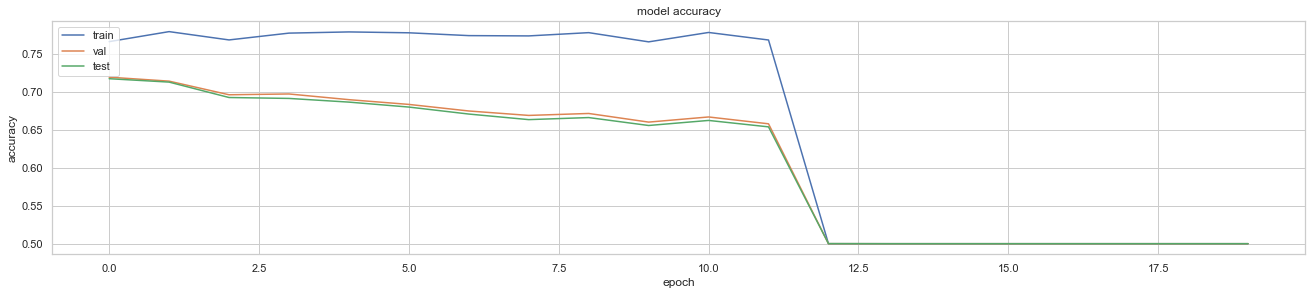

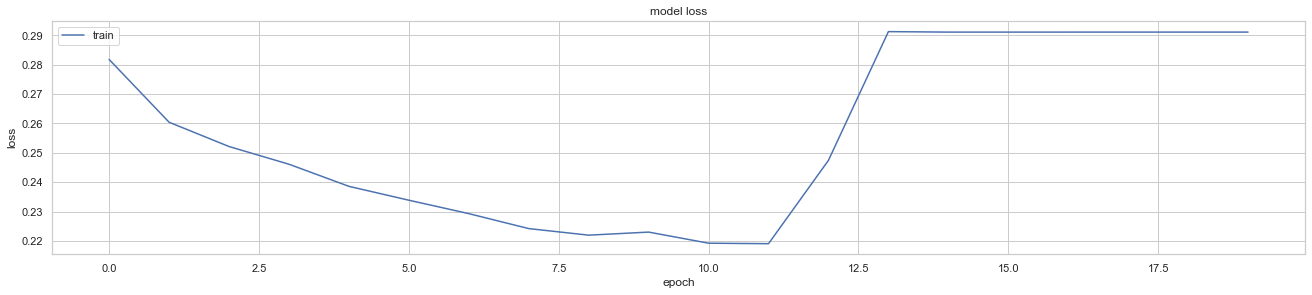

In [31]:
# summarize history for accuracy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

plt.figure(figsize = (20,4))
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.plot(test_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper left')
plt.savefig('./accuracy.png')

# summarize history for loss
plt.figure(figsize = (20,4))
plt.plot(loss_)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('./loss.png')